
# SQL Over Anything with Spark

- Examples From Video Lecture 

In [1]:
import pyspark
from pyspark.sql import SparkSession

bucket = "e-drill"

spark = SparkSession.builder \
    .master("local") \
    .appName('jupyter-pyspark') \
        .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:3.1.2,org.apache.spark:spark-avro_2.12:3.1.2")\
        .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
        .config("spark.hadoop.fs.s3a.access.key", "minio") \
        .config("spark.hadoop.fs.s3a.secret.key", "SU2orange!") \
        .config("spark.hadoop.fs.s3a.fast.upload", True) \
        .config("spark.hadoop.fs.s3a.path.style.access", True) \
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR") # Keeps the noise down!!!

Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-30663c14-27be-4f19-b3d3-ea4092fe4aac;1.0
	confs: [default]


:: loading settings :: url = jar:file:/usr/local/spark-3.1.2-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.hadoop#hadoop-aws;3.1.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.271 in central
	found org.apache.spark#spark-avro_2.12;3.1.2 in central
	found org.spark-project.spark#unused;1.0.0 in central
downloading https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.1.2/hadoop-aws-3.1.2.jar ...
	[SUCCESSFUL ] org.apache.hadoop#hadoop-aws;3.1.2!hadoop-aws.jar (52ms)
downloading https://repo1.maven.org/maven2/org/apache/spark/spark-avro_2.12/3.1.2/spark-avro_2.12-3.1.2.jar ...
	[SUCCESSFUL ] org.apache.spark#spark-avro_2.12;3.1.2!spark-avro_2.12.jar (34ms)
downloading https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.11.271/aws-java-sdk-bundle-1.11.271.jar ...
	[SUCCESSFUL ] com.amazonaws#aws-java-sdk-bundle;1.11.271!aws-java-sdk-bundle.jar (5540ms)
downloading https://repo1.maven.org/maven2/org/spark-project/spark/unused/1.0.0/unused-1.0.0.jar ...
	[SUCCESSFUL ] org.spark-project.spark#unused;1.0.0!unused.jar (21ms)
:: resolution report 

In [5]:
c = spark.read.csv("file:///home/jovyan/datasets/customers/customers.csv", 
                   inferSchema=True, header=True)
c.createOrReplaceTempView("customers") # now its an SQL table in Spark!
query = '''
SELECT  Email, Gender, State, `Months Customer`
FROM customers 
    WHERE State = 'NY'
'''
df = spark.sql(query)
df.toPandas()

,Email,Gender,State,Months Customer
0,afresco@dayrep.com,M,NY,1
1,cling@superrito.com,F,NY,6
2,etasomthin@superrito.com,M,NY,28
3,jpoole@dayrep.com,F,NY,12
4,ojouglad@einrot.com,M,NY,36
5,rovlight@dayrep.com,M,NY,42
6,sladd@superrito.com,M,NY,10
7,titupp@superrito.com,F,NY,42
8,tpani@superrito.com,M,NY,1


## Setup

- Put data in the right places!!!
- Run these cells to ensure you have the data for the examples

In [2]:
! pip install -q minio

In [10]:
from minio import Minio

# Make the minio bucket
client = Minio("minio:9000","minio","SU2orange!", secure=False)
not client.bucket_exists(bucket) and client.make_bucket(bucket)

# open the example(s)
gp = spark.read.json("file:///home/jovyan/datasets/json-samples/google-places.json")
c = spark.read.csv("file:///home/jovyan/datasets/customers/customers.csv", inferSchema=True, header=True)
s = spark.read.csv("file:///home/jovyan/datasets/customers/surveys.csv",inferSchema=True, header=True)
g = spark.read.csv("file:///home/jovyan/datasets/grades/*.tsv",inferSchema=False, header=False, sep="\t")
k = spark.read.csv("file:///home/jovyan/datasets/stocks/stocks.csv",inferSchema=True, header=True)
k.show()
# Put the examples in minio
gp.write.mode("Overwrite").json(f"s3a://{bucket}/google-places.json")
c.write.mode("Overwrite").csv(f"s3a://{bucket}/customers.csv",header=True)
s.write.mode("Overwrite").csv(f"s3a://{bucket}/surveys.csv",header=True)
g.write.mode("Overwrite").csv(f"s3a://{bucket}/grades.csv",header=False, sep=",")
g.write.mode("Overwrite").parquet(f"s3a://{bucket}/grades.parquet")
k.write.mode("Overwrite").csv(f"s3a://{bucket}/stocks.csv",header=True,sep=",")

#put the examples in HDFS
gp.write.mode("Overwrite").json(f"hdfs://namenode/user/root/{bucket}/google-places.json")
c.write.mode("Overwrite").csv(f"hdfs://namenode/user/root/{bucket}/customers.csv",header=True)
s.write.mode("Overwrite").csv(f"hdfs://namenode/user/root/{bucket}/surveys.csv",header=True)
g.write.mode("Overwrite").csv(f"hdfs://namenode/user/root/{bucket}/grades.csv",header=False, sep=",")
g.write.mode("Overwrite").parquet(f"hdfs://namenode/user/root/{bucket}/grades.parquet")

+-------+------+
|  price|symbol|
+-------+------+
| 126.82|  AAPL|
|3098.12|  AMZN|
| 251.11|    FB|
|1725.05|  GOOG|
| 128.39|   IBM|
| 212.55|  MSFT|
|   78.0|   NET|
|  497.0|  NFLX|
|  823.8|  TSLA|
|  45.11|  TWTR|
+-------+------+



IllegalArgumentException: java.net.UnknownHostException: namenode

## Spark SQL

- Spark Supports ANSI Standard SQL
- Once you register a DataFrame as a Temp View, you can query it like an SQL table.
- The output is a DataFrame, that you can maniuplate further with spark!

In [7]:
c.createOrReplaceTempView("customers")
s.createOrReplaceTempView("surveys")
c.printSchema()
s.printSchema()

root
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Last IP Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total Orders: integer (nullable = true)
 |-- Total Purchased: integer (nullable = true)
 |-- Months Customer: integer (nullable = true)

root
 |-- Email: string (nullable = true)
 |-- Twitter Username: string (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Household Income: string (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Favorite Department: string (nullable = true)



In [8]:
query = '''
select c.Email, c.Gender, c.State, c.`Months Customer`, s.`Own Home`, s.`Household Income`
from customers c left join surveys s on 
        c.Email = s.Email
    where c.State = 'NY'
    and c.`Months Customer` > 5
    and s.`Own Home` is not null
'''
df = spark.sql(query)
df.show()
df.printSchema()

+--------------------+------+-----+---------------+--------+--------------------+
|               Email|Gender|State|Months Customer|Own Home|    Household Income|
+--------------------+------+-----+---------------+--------+--------------------+
|etasomthin@superr...|     M|   NY|             28|      No|               39000|
|   jpoole@dayrep.com|     F|   NY|             12|     Yes|Prefer not to Answer|
| ojouglad@einrot.com|     M|   NY|             36|      No|               65000|
| rovlight@dayrep.com|     M|   NY|             42|      No|               28000|
| sladd@superrito.com|     M|   NY|             10|     Yes|               52000|
+--------------------+------+-----+---------------+--------+--------------------+

root
 |-- Email: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Months Customer: integer (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Household Income: string (nullable = true)



In [88]:
c.createOrReplaceTempView("customers")
s.createOrReplaceTempView("surveys")
c.printSchema()
s.printSchema()

root
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Last IP Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total Orders: integer (nullable = true)
 |-- Total Purchased: integer (nullable = true)
 |-- Months Customer: integer (nullable = true)

root
 |-- Email: string (nullable = true)
 |-- Twitter Username: string (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Household Income: string (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Favorite Department: string (nullable = true)



In [9]:

query = '''
select c.Email, c.Gender, c.State, c.`Months Customer`, s.`Own Home`, 
    case s.`Household Income` 
        when 'Prefer not to Answer' then null 
        else cast(s.`Household Income` as DOUBLE) 
    end as Income
from customers c left join surveys s on 
        c.Email = s.Email
    where c.State = 'NY'
    and c.`Months Customer` > 5
    and s.`Own Home` is not null
'''
df = spark.sql(query)
df.show()

+--------------------+------+-----+---------------+--------+-------+
|               Email|Gender|State|Months Customer|Own Home| Income|
+--------------------+------+-----+---------------+--------+-------+
|etasomthin@superr...|     M|   NY|             28|      No|39000.0|
|   jpoole@dayrep.com|     F|   NY|             12|     Yes|   null|
| ojouglad@einrot.com|     M|   NY|             36|      No|65000.0|
| rovlight@dayrep.com|     M|   NY|             42|      No|28000.0|
| sladd@superrito.com|     M|   NY|             10|     Yes|52000.0|
+--------------------+------+-----+---------------+--------+-------+



In [10]:
df.printSchema()
df.explain()
df.createOrReplaceTempView("v_ny_customer_analysis")

root
 |-- Email: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Months Customer: integer (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Income: double (nullable = true)

== Physical Plan ==
*(2) Project [Email#368, Gender#369, State#372, Months Customer#375, Own Home#406, CASE WHEN (Household Income#405 = Prefer not to Answer) THEN null ELSE cast(Household Income#405 as double) END AS Income#656]
+- *(2) BroadcastHashJoin [Email#368], [Email#402], Inner, BuildRight, false
   :- *(2) Filter ((((isnotnull(State#372) AND isnotnull(Months Customer#375)) AND (State#372 = NY)) AND (Months Customer#375 > 5)) AND isnotnull(Email#368))
   :  +- FileScan csv [Email#368,Gender#369,State#372,Months Customer#375] Batched: false, DataFilters: [isnotnull(State#372), isnotnull(Months Customer#375), (State#372 = NY), (Months Customer#375 > 5..., Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/datasets/customers/custome

## Spark SQL works with Nested Data

In [11]:
gp.printSchema()

root
 |-- business_status: string (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- location: struct (nullable = true)
 |    |    |-- lat: double (nullable = true)
 |    |    |-- lng: double (nullable = true)
 |    |-- viewport: struct (nullable = true)
 |    |    |-- northeast: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lng: double (nullable = true)
 |    |    |-- southwest: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lng: double (nullable = true)
 |-- icon: string (nullable = true)
 |-- icon_background_color: string (nullable = true)
 |-- icon_mask_base_uri: string (nullable = true)
 |-- name: string (nullable = true)
 |-- opening_hours: struct (nullable = true)
 |    |-- open_now: boolean (nullable = true)
 |-- photos: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- height: long (nullable = true)
 |    |    |-- html_attributi

In [12]:
gp.createOrReplaceTempView("googleplaces")
query = '''
select name, geometry.location.lat, geometry.location.lng, explode(types) as type from googleplaces
'''
spark.sql(query).show()

+--------------------+-----------------+------------------+-----------------+
|                name|              lat|               lng|             type|
+--------------------+-----------------+------------------+-----------------+
|            Syracuse|       43.0481221|-76.14742439999999|         locality|
|            Syracuse|       43.0481221|-76.14742439999999|        political|
|Crowne Plaza Syra...|       43.0476078|       -76.1417642|          lodging|
|Crowne Plaza Syra...|       43.0476078|       -76.1417642|point_of_interest|
|Crowne Plaza Syra...|       43.0476078|       -76.1417642|    establishment|
|  The Parkview Hotel|       43.0476157|        -76.140986|          lodging|
|  The Parkview Hotel|       43.0476157|        -76.140986|point_of_interest|
|  The Parkview Hotel|       43.0476157|        -76.140986|    establishment|
|Jefferson Clinton...|       43.0472894|-76.15385049999999|          lodging|
|Jefferson Clinton...|       43.0472894|-76.15385049999999|point

## Registering a UDF for use in Spark SQL


In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import * 

@udf(returnType=StringType()) 
def upperCase(str):
    return str.upper()

spark.udf.register("upperCase", upperCase)

spark.sql("select Email, upperCase(Email), Gender from v_ny_customer_analysis").show()

+--------------------+--------------------+------+
|               Email|           uc(Email)|Gender|
+--------------------+--------------------+------+
|etasomthin@superr...|ETASOMTHIN@SUPERR...|     M|
|   jpoole@dayrep.com|   JPOOLE@DAYREP.COM|     F|
| ojouglad@einrot.com| OJOUGLAD@EINROT.COM|     M|
| rovlight@dayrep.com| ROVLIGHT@DAYREP.COM|     M|
| sladd@superrito.com| SLADD@SUPERRITO.COM|     M|
+--------------------+--------------------+------+



## Listing views in Your Session

In [100]:
spark.sql("show views").show()

+---------+--------------------+-----------+
|namespace|            viewName|isTemporary|
+---------+--------------------+-----------+
|         |           customers|       true|
|         |        googleplaces|       true|
|         |             surveys|       true|
|         |v_ny_customer_ana...|       true|
+---------+--------------------+-----------+



# Big Data To Small Data

Using the `.toPandas()` function will materilaize the spark DataFrame as a Python Pandas dataframe. This allows us to use small-data features available in Python as our code is no longer executing on the cluster.

## Graphing Output

- A Spark DataFrame can be converted to a Python Pandas dataframe with the `toPandas()` function.
- Once its in Pandas you can plot with standard plotting libraries.
- https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html


<AxesSubplot:xlabel='Email'>

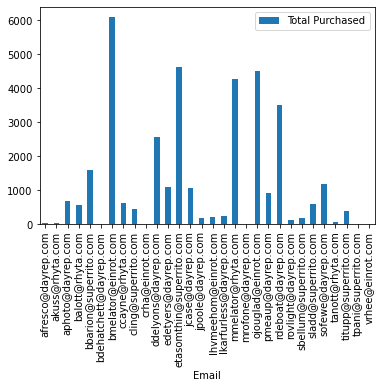

In [17]:
c.toPandas().plot.bar(x="Email", y="Total Purchased")

## IPywidgets

- IPy Widgets allows us to create interactive notebooks
- https://ipywidgets.readthedocs.io/en/latest/
- This is a great example of going from "Big Data" to "Small Data"
- As a rule, we don't want to produce small data (Pandas DataFrame) until we have mapped or reduced results.

In [4]:
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual
c = spark.read.csv("file:///home/jovyan/datasets/customers/customers.csv", inferSchema=True, header=True)

display(HTML("<h1>Customers By State</h1>"))
states = c.select("State").distinct().toPandas()["State"].values
states.sort()
@interact(state=states)
def main(state :str):
    rows = c.where( c.State == state).toPandas()
    display(rows)

interactive(children=(Dropdown(description='state', options=('AZ', 'CA', 'CT', 'FL', 'IL', 'KS', 'MA', 'ME', '…

In [1]:
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual, widgets

display(HTML("<h1>Customers By Total Purchased</h1>"))
rangewidget = widgets.IntRangeSlider(
    value=[10, 1000],
    min=0,
    max=5000,
    step=10,
    description='Total Purchased:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

c.createOrReplaceTempView("customers")

@interact_manual(purchased=rangewidget)
def main(purchased: int):
    query = f'select * from customers where `Total Purchased` between {purchased[0]} and {purchased[1]}'
    display(spark.sql(query).toPandas())
    

NameError: name 'c' is not defined

In [8]:
s.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Twitter Username: string (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Household Income: string (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Favorite Department: string (nullable = true)



In [9]:
s.orderBy("Favorite Department", ascending = False).show()


+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Email|Twitter Username|      Marital Status|    Household Income|            Own Home|           Education| Favorite Department|
+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|               75000|                 Yes|       4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|               39000|                  No|       2 Year Degree|Prefer not to Answer|
| sladd@superrito.com|           sladd|             Married|               52000|                 Yes|       2 Year Degree|                None|
|     akuss@rhyta.com|           akuss|              Single|               22500|                  No|         High School|       

In [12]:
s.orderBy(s["Favorite Department"],ascending = False).show()

+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Email|Twitter Username|      Marital Status|    Household Income|            Own Home|           Education| Favorite Department|
+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|               75000|                 Yes|       4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|               39000|                  No|       2 Year Degree|Prefer not to Answer|
| sladd@superrito.com|           sladd|             Married|               52000|                 Yes|       2 Year Degree|                None|
|     akuss@rhyta.com|           akuss|              Single|               22500|                  No|         High School|       

In [16]:
s.filter( "`Favorite Department` LIKE 'Prefer%' " ).show()


+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|               Email|Twitter Username|      Marital Status|Household Income|Own Home|    Education| Favorite Department|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|           75000|     Yes|4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|           39000|      No|2 Year Degree|Prefer not to Answer|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+



In [23]:
from pyspark.sql.functions import *
s.filter(col("Favorite Department").startswith("Prefer") ).show()

+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|               Email|Twitter Username|      Marital Status|Household Income|Own Home|    Education| Favorite Department|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|           75000|     Yes|4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|           39000|      No|2 Year Degree|Prefer not to Answer|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+



In [24]:
s.createOrReplaceTempView("surveys")

In [26]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |  surveys|       true|
+--------+---------+-----------+



In [27]:
z =spark.sql("select * from surveys where `Favorite Department` like 'Prefer%'")

+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|               Email|Twitter Username|      Marital Status|Household Income|Own Home|    Education| Favorite Department|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|           75000|     Yes|4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|           39000|      No|2 Year Degree|Prefer not to Answer|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+



In [28]:
y = s.filter(col("Favorite Department").startswith("Prefer") )
z =spark.sql("select * from surveys where `Favorite Department` like 'Prefer%'")

In [29]:
y.explain()

== Physical Plan ==
*(1) Filter (isnotnull(Favorite Department#99) AND StartsWith(Favorite Department#99, Prefer))
+- FileScan csv [Email#93,Twitter Username#94,Marital Status#95,Household Income#96,Own Home#97,Education#98,Favorite Department#99] Batched: false, DataFilters: [isnotnull(Favorite Department#99), StartsWith(Favorite Department#99, Prefer)], Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/datasets/customers/surveys.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Favorite Department), StringStartsWith(Favorite Department,Prefer)], ReadSchema: struct<Email:string,Twitter Username:string,Marital Status:string,Household Income:string,Own Hom...




In [30]:
z.explain()

== Physical Plan ==
*(1) Filter (isnotnull(Favorite Department#99) AND StartsWith(Favorite Department#99, Prefer))
+- FileScan csv [Email#93,Twitter Username#94,Marital Status#95,Household Income#96,Own Home#97,Education#98,Favorite Department#99] Batched: false, DataFilters: [isnotnull(Favorite Department#99), StartsWith(Favorite Department#99, Prefer)], Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/datasets/customers/surveys.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Favorite Department), StringStartsWith(Favorite Department,Prefer)], ReadSchema: struct<Email:string,Twitter Username:string,Marital Status:string,Household Income:string,Own Hom...




In [32]:
query = '''

SELECT *
    FROM  surveys
    WHERE `Favorite Department` like 'Prefer%'

'''

spark.sql(query)

+--------------------+
|               Email|
+--------------------+
|lhvmeehom@einrot.com|
|etasomthin@superr...|
+--------------------+



In [ ]:
#pyspark
spark.read.csv("s3a://....")

In [ ]:
spark.read.format("csv").load("s3a:///...")

In [ ]:
s.write.format("foo.bvar.avro").mode("errorifexists")\
    .option("sep","-").option("header",True).save("file:///foo.csv")

In [38]:
gp.select("geometry.location.lat",gp.geometry.location.lng.alias("lng")  ).show()

+-----------------+------------------+
|              lat|               lng|
+-----------------+------------------+
|       43.0481221|-76.14742439999999|
|       43.0476078|       -76.1417642|
|       43.0476157|        -76.140986|
|       43.0472894|-76.15385049999999|
|       43.0488846|       -76.1561175|
|43.05264399999999|-76.14681999999999|
|       43.0391534|       -76.1351158|
|       43.0464172|-76.13539879999999|
|       43.0526411|-76.15469379999999|
|43.04396249999999|-76.13607999999999|
|43.04123120000001|       -76.1338203|
|       43.0446639|       -76.1481366|
|       43.0457297|       -76.1483396|
|       43.0414634|        -76.138599|
|        43.048302|        -76.155406|
|        43.050228|        -76.154804|
|43.03901020000001|       -76.1389683|
|        43.042709|        -76.140511|
|43.04229789999999|       -76.1395979|
|43.03426049999999|       -76.1242405|
+-----------------+------------------+



In [39]:
gp.select(col("geometry.location.lat").alias("g.l.lat"),gp.geometry.location.lng.alias("g.l.lng")  ).show()

+-----------------+------------------+
|          g.l.lat|           g.l.lng|
+-----------------+------------------+
|       43.0481221|-76.14742439999999|
|       43.0476078|       -76.1417642|
|       43.0476157|        -76.140986|
|       43.0472894|-76.15385049999999|
|       43.0488846|       -76.1561175|
|43.05264399999999|-76.14681999999999|
|       43.0391534|       -76.1351158|
|       43.0464172|-76.13539879999999|
|       43.0526411|-76.15469379999999|
|43.04396249999999|-76.13607999999999|
|43.04123120000001|       -76.1338203|
|       43.0446639|       -76.1481366|
|       43.0457297|       -76.1483396|
|       43.0414634|        -76.138599|
|        43.048302|        -76.155406|
|        43.050228|        -76.154804|
|43.03901020000001|       -76.1389683|
|        43.042709|        -76.140511|
|43.04229789999999|       -76.1395979|
|43.03426049999999|       -76.1242405|
+-----------------+------------------+



In [41]:
gp.select("geometry.location.lat",gp.geometry.location.lng ).toDF("g.l.lat","g.l.lng").show()

+-----------------+------------------+
|          g.l.lat|           g.l.lng|
+-----------------+------------------+
|       43.0481221|-76.14742439999999|
|       43.0476078|       -76.1417642|
|       43.0476157|        -76.140986|
|       43.0472894|-76.15385049999999|
|       43.0488846|       -76.1561175|
|43.05264399999999|-76.14681999999999|
|       43.0391534|       -76.1351158|
|       43.0464172|-76.13539879999999|
|       43.0526411|-76.15469379999999|
|43.04396249999999|-76.13607999999999|
|43.04123120000001|       -76.1338203|
|       43.0446639|       -76.1481366|
|       43.0457297|       -76.1483396|
|       43.0414634|        -76.138599|
|        43.048302|        -76.155406|
|        43.050228|        -76.154804|
|43.03901020000001|       -76.1389683|
|        43.042709|        -76.140511|
|43.04229789999999|       -76.1395979|
|43.03426049999999|       -76.1242405|
+-----------------+------------------+



In [45]:
from pyspark import SparkFiles

In [50]:
spark.sparkContext.addFile("https://raw.githubusercontent.com/mafudge/datasets/master/crime/nys-crime-1960-2012.csv")
df = spark.read.option("inferSchema",True).option("header", True)\
    .csv(SparkFiles.get("nys-crime-1960-2012.csv"))
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Population: double (nullable = true)
 |-- Violent crime total: double (nullable = true)
 |-- Murder and nonnegligent Manslaughter: double (nullable = true)
 |-- Forcible rape: double (nullable = true)
 |-- Robbery: double (nullable = true)
 |-- Aggravated assault: double (nullable = true)
 |-- Property crime total: double (nullable = true)
 |-- Burglary: double (nullable = true)
 |-- Larceny-theft: double (nullable = true)
 |-- Motor vehicle theft: double (nullable = true)
 |-- _c11: string (nullable = true)



In [49]:
SparkFiles.get("nys-crime-1960-2012.csv")

'/tmp/spark-69583df6-d589-41c4-83a9-4de535ffd62c/userFiles-00fd3eba-9da4-466b-b3d8-c534dab26904/nys-crime-1960-2012.csv'

In [6]:
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual


@interact_manual(name="", age=(1,99), retired=False, hobbies=["Biking","Skiing"])
def onclick(name,age,retired,hobbies):
    display(HTML(f"<p>{name}, {age} {retired} {hobbies}"))
    


interactive(children=(Text(value='', description='name'), IntSlider(value=50, description='age', max=99, min=1…